**반도체 공정 데이터를 활용한 이상 예측하기**

출처: https://archive.ics.uci.edu/ml/datasets/SECOM


UCI에서 제공하는 SECOM 공정에서 측정된 센서 데이터를 기반으로 한 데이터를 바탕으로 공정 이상을 예측해보는 분류 모델을 구현해보고, <br>공정 이상 시 어떠한 센서들이 중요한 역할을 하는지 알아봅니다.



---




# **1. 데이터 읽기**

In [1]:
# 필요한 모듈 삽입
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/SecomAnalysis/data/uci-secom.csv')
display(df.head(2),df.tail(2))

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.0,2916.50,-4043.75,751.00,0.8955,1.7730,3.049,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.5,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.390,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.006,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.006,208.2045,-1


,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,0.0032,0.9694,197.2448,0.0,9.7354,401.9153,9.863,0.974,187.3818,12.3937,1.3868,-5271.75,2676.5,-4001.50,394.75,1.2875,1.9880,7.3255,70.5111,2.9667,0.2386,3.2803,84.5602,9.1930,50.6547,64.0158,49.3453,66.2301,86.3130,...,1.33,0.0949,6.7381,0.5058,27.0176,3.6251,1.8156,1.0108,0.1920,0.0435,18.9966,264.272,0.5671,4.98,0.0877,2.0902,0.0382,1.8844,15.4662,534.3936,1.9098,9.13,0.3669,3.2524,0.1040,1.7085,19.2104,0.0262,0.0245,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1
1566,2008-10-17 06:07:00,2944.92,2450.76,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.4790,1.4048,-5319.50,2668.0,-3951.75,-425.00,1.3020,2.0085,7.3395,73.0667,2.5889,0.2021,3.3860,83.3424,8.7786,50.1940,64.2226,49.8060,66.2251,86.4039,...,1.33,0.0949,6.7381,0.5058,27.0176,3.6251,1.8156,1.0827,0.2327,0.0678,21.4914,257.974,0.6193,8.42,0.1307,3.0894,0.0493,3.2639,21.1128,528.7918,2.0831,6.81,0.4774,2.2727,0.1495,1.2878,22.9183,0.0117,0.0162,0.0045,137.7844,0.4987,0.0181,0.0040,3.6275,0.0117,0.0162,0.0045,137.7844,-1


In [4]:
# info()를 이용하여 dataframe의 정보를 요약해서 출력
df.info()

# shape로 몇 행과 몇 열로 되어있는지 알 수 있습니다. => 1567행, 592열
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


(1567, 592)

In [5]:
# 수치형 변수의 데이터 정보를 요약하여 출력
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1557.000000,1567.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,...,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1566.000000,1566.000000,1566.000000,1566.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,618.000000,618.000000,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,0.000146,0.964353,199.956809,0.0,9.005371,413.086035,9.907603,0.971444,190.047354,12.481034,1.405054,-5618.393610,2699.378435,-3806.299734,-298.598136,1.203845,1.938477,6.638628,69.499532,2.366197,0.184159,3.673189,85.337469,8.960279,50.582639,64.555787,49.417370,66.221274,86.836577,118.679554,...,1.230712,0.276688,7.703874,0.503657,57.746537,4.216905,1.623070,0.995009,0.325708,0.072443,32.284956,262.729683,0.679641,6.444985,0.145610,2.610870,0.060086,2.452417,21.117674,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.021615,0.016829,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,0.009302,0.012452,3.257276,0.0,2.796596,17.221095,2.403867,0.012062,2.781041,0.217965,0.016737,626.822178,295.498535,1380.162148,2902.690117,0.177600,0.189495,1.244249,3.461181,0.408694,0.032944,0.535322,2.026549,1.344456,1.182618,2.574749,1.182619,0.304141,0.446756,1.807221,...,1.361117,0.276231,2.192647,0.598852,35.207552,1.280008,1.870433,0.083860,0.201392,0.051578,19.026081,7.630585,0.121758,2.633583,0.081122,1.032761,0.032761,0.996644,10.213294,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.011730,0.009640,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,-0.034900,0.655400,182.094000,0.0,2.249300,333.448600,4.469600,0.579400,169.177400,9.877300,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,59.400000,0.666700,0.034100,2.069800,83.182900,7.603200,49.834800,63.677400,40.228900,64.919300,84.732700,111.712800,...,0.120000,0.018700,2.786000,0.052000,4.826900,1.496700,0.164600,0.891900,0.069900,0.017700,7.236900,242.286000,0.304900,0.970000,0.022400,0.412200,0.009100,0.370600,3.250400,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.003200,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,-0.005600,0.958100,198.130700,0.0,7.094875,406.127400,9.567625,0.968200,188.299825,12.460000,1.396500,-5933.250000,2578.000000,-4371.750000,-1476.000000,1.094800,1.906500,5.263700,67.377800,2.088900,0.161700,3.362700,84.490500,8.580000,50.252350,64.024800,49.421200,66.040650,86.578300,118.015600,...,0.870000,0.094900,6.738100,0.343800,27.017600,3.625100,1.182900,0.9



---




# **2. 데이터 정제**

In [6]:
# 결측값 정보를 출력
df.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

**모든 데이터를 사용하기 위해, fillna() 함수를 이용하여 결측값을 0으로 대체**

In [7]:
# np.NaN => 결측값 
df = df.replace(np.NaN, 0)

# 결측값 정보를 출력합니다.
df.isnull().sum()

Time         0
0            0
1            0
2            0
3            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 592, dtype: int64

**'Time' 변수의 데이터는 pass/fail을 예측하는데 큰 영향이 없음 => drop을 이용하여 삭제**

In [8]:
# axis=1은 열 방향으로 동작. 
df = df.drop(columns = ['Time'], axis = 1)

df.shape

(1567, 591)

# **3. 데이터 시각화**

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

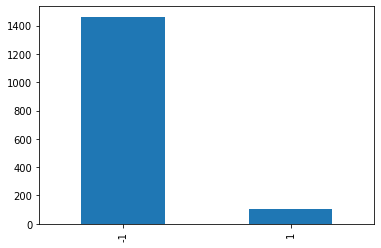

In [9]:
#'Pass/Fail' 시각화
df['Pass/Fail'].value_counts().plot(kind='bar')

df['Pass/Fail'].value_counts()



---



# **4. 데이터 전처리**

(1) 전체 데이터를 feature 데이터인 x와 label 데이터인 y로 분리하기 <br>
(2) StandardScaler를 통한 데이터 표준화하기

In [10]:
# 머신러닝의 feature 데이터는 x, label 데이터는 y에 저장
x = df.drop(columns = ['Pass/Fail'], axis = 1)

y = df['Pass/Fail']

In [11]:
# 1차원 벡터 형태로 출력하기 위해 ravel 사용. 
y = y.to_numpy().ravel() 
y

array([-1, -1,  1, ..., -1, -1, -1])

In [12]:
# data 폴더 내의 uci-secom-test.csv를 DataFrame으로 읽고 x_test, y_test로 분리.
df_test = pd.read_csv('/content/drive/MyDrive/SecomAnalysis/data/uci-secom-test.csv')
x_test = df_test.drop(columns = ['Pass/Fail'], axis = 1)
y_test = df_test['Pass/Fail'].to_numpy().ravel() 

# **5. 데이터 정규화**

각 변수 마다의 스케일 차이를 맞추기 위하여 표준화를 수행해야 한다.<br>
데이터 각각이 평균이 0이고 분산이 1인 가우시안 정규 분포를 형태와 가까워지도록 변환합니다.

In [14]:
# 정규화를 위해서 StandardScaler 사용
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [15]:
# x_train에 있는 데이터에 맞춰 정규화를 진행합니다. 
x_train = sc.fit_transform(x)
x_test = sc.transform(x_test)
y_train = y

In [16]:
#mean()으로 평균을 구하고 var()로 분산을 구합니다.
x_train_sc = pd.DataFrame(data=x_train)
print("평균")
print(x_train_sc.mean())
print("분산")
print(x_train_sc.var())

평균
0      1.183199e-17
1     -9.915489e-16
2      1.299464e-15
3     -2.323887e-17
4     -4.587109e-17
           ...     
585   -4.137653e-17
586    5.023989e-16
587    2.378929e-16
588   -5.119992e-16
589    8.218626e-17
Length: 590, dtype: float64
분산
0      1.000639
1      1.000639
2      1.000639
3      1.000639
4      1.000639
         ...   
585    1.000639
586    1.000639
587    1.000639
588    1.000639
589    1.000639
Length: 590, dtype: float64




---



# **6. 머신러닝 학습**

**1. 로지스틱 분류기(logistic regression classifier)**

In [18]:
# 로지스틱 분류기 모델 class를 가져 옵니다.
from sklearn.linear_model import LogisticRegression

# max_iter는 로지스틱 알고리즘의 반복 횟수를 정하는 파라미터
model = LogisticRegression(max_iter=5000)

# 데이터를 학습시킬 때는 fit 함수를 사용. 
model.fit(x_train, y_train)

# score 함수를 사용하여 모델의 성능을 확인. 
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9738353541799617
0.845


In [19]:
# Logistic Regression의 중요도를 계산.
# 가중치 값들의 크기로 판단하기에 .coef_로 해당 값들을 불러온다.
abs_coef = np.abs(model.coef_).ravel()
abs_coef

array([1.96695024e-02, 1.55757190e-01, 2.29996871e-01, 2.39614128e-01,
       3.21143791e-02, 4.46618378e-01, 1.24359224e-01, 4.99566407e-01,
       1.51318173e-01, 3.26941219e-01, 1.82686987e-01, 3.35677849e-02,
       2.09863930e-01, 0.00000000e+00, 5.07569142e-01, 2.70040408e-01,
       5.76687104e-01, 2.80723813e-01, 3.48462503e-01, 1.46588384e-01,
       2.64004998e-01, 5.32811823e-01, 1.51957494e-02, 1.55659738e-01,
       2.19335875e-01, 9.30199205e-01, 5.00508044e-01, 5.97537950e-02,
       1.27397239e-01, 9.00013228e-01, 6.57549310e-01, 7.48520127e-02,
       2.56482644e-01, 4.32751014e-01, 3.14251167e-02, 4.05768808e-01,
       1.99479122e-01, 9.98832105e-02, 1.11856458e-01, 2.00376371e-01,
       4.39540242e-01, 1.75668410e-01, 2.75846494e-04, 1.88399744e-01,
       1.89392106e-02, 5.38509420e-01, 2.55575634e-01, 2.44607320e-01,
       3.85249486e-01, 2.75846494e-04, 2.45887322e-01, 2.00960429e-01,
       0.00000000e+00, 4.37520345e-01, 6.24795433e-01, 2.74786592e-01,
      

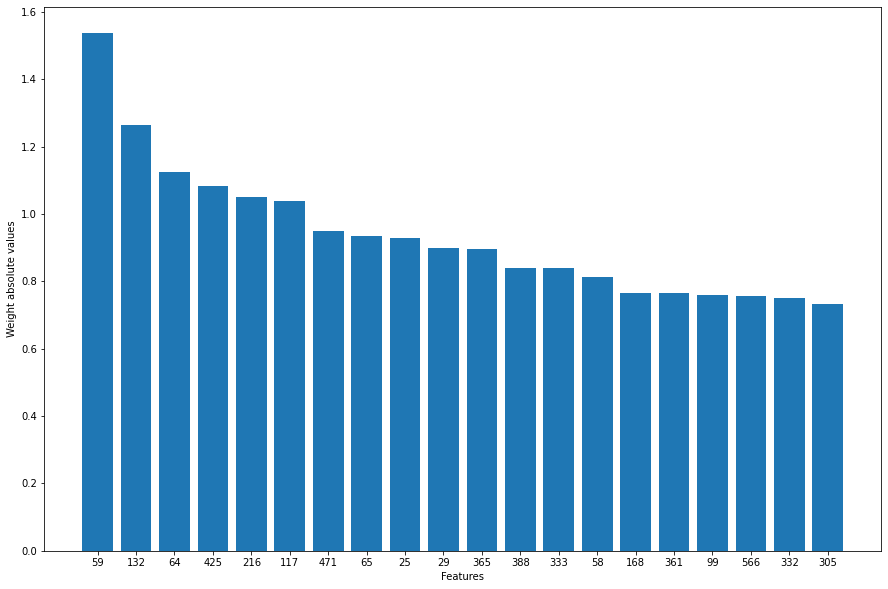

In [21]:
# Logistic Regression의 feature 별 중요도 상위 20개를 그래프로 출력
# 상위 20개의 feature 정보를 출력하기 위하여 sorting을 수행하고 해당 feature 번호를 LR_imort_x에 저장.
LR_import_x = [str(i[0]) for i in sorted(enumerate(abs_coef), key=lambda x:x[1], reverse=True)]

plt.bar(LR_import_x[:20], sorted(abs_coef, reverse=True)[:20])

plt.rcParams['figure.figsize'] = (20, 15)
plt.xlabel('Features')
plt.ylabel('Weight absolute values')
plt.show()

**2. 다양한 분류 모델 학습**

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


#여러 모델을 append해서 추가. 
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))  # LDA 모델
models.append(('KNN', KNeighborsClassifier()))  # KNN 모델
models.append(('CART', DecisionTreeClassifier()))  # 의사결정트리 모델
models.append(('NB', GaussianNB()))  # 가우시안 나이브 베이즈 모델
models.append(('RF', RandomForestClassifier()))  # 랜덤포레스트 모델
models.append(('SVM', SVC(gamma='auto')))  # SVM 모델
models.append(('XGB', XGBClassifier()))  # XGB 모델

for name, model in models:
    # fit으로 model을 학습. 
    model.fit(x_train, y_train)

    # score 함수를 사용하여 모델의 성능을 확인.
    msg = "%s - train_score : %f, test score : %f" % (name, model.score(x_train, y_train), model.score(x_test, y_test))
    print(msg)

LDA - train_score : 0.971921, test score : 0.883333
KNN - train_score : 0.934269, test score : 0.548333
CART - train_score : 1.000000, test score : 0.656667
NB - train_score : 0.181238, test score : 0.570000
RF - train_score : 1.000000, test score : 0.503333
SVM - train_score : 0.938098, test score : 0.488333
XGB - train_score : 0.989789, test score : 0.590000


# **7. 평가 및 예측**

In [23]:
# sklearn에서 제공하는 recall_score, precision_score를 사용하여 recall과 precision 결과물을 출력.
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print("Recall score: {}".format(recall_score(y_test, models[0][1].predict(x_test))))
print("Precision score: {}".format(precision_score(y_test, models[0][1].predict(x_test))))

Recall score: 0.7795527156549521
Precision score: 0.9959183673469387


In [24]:
# 0번부터 9번까지 10개를 테스트 해보기.
for i in range(10): 
    
    prediction = models[0][1].predict(x_test[i].reshape(1,-1))
    
    print("{} 번째 테스트 데이터의 예측 결과: {}, 실제 데이터: {}".format(i, prediction[0], y_test[i]))

0 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: 1
1 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: -1
2 번째 테스트 데이터의 예측 결과: -1, 실제 데이터: -1
3 번째 테스트 데이터의 예측 결과: -1, 실제 데이터: 1
4 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: 1
5 번째 테스트 데이터의 예측 결과: -1, 실제 데이터: -1
6 번째 테스트 데이터의 예측 결과: -1, 실제 데이터: -1
7 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: 1
8 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: 1
9 번째 테스트 데이터의 예측 결과: 1, 실제 데이터: 1




---



# **8. 59번 센서 시각화 하기**

Text(0.5, 1.0, '59 Sensor Measurements')

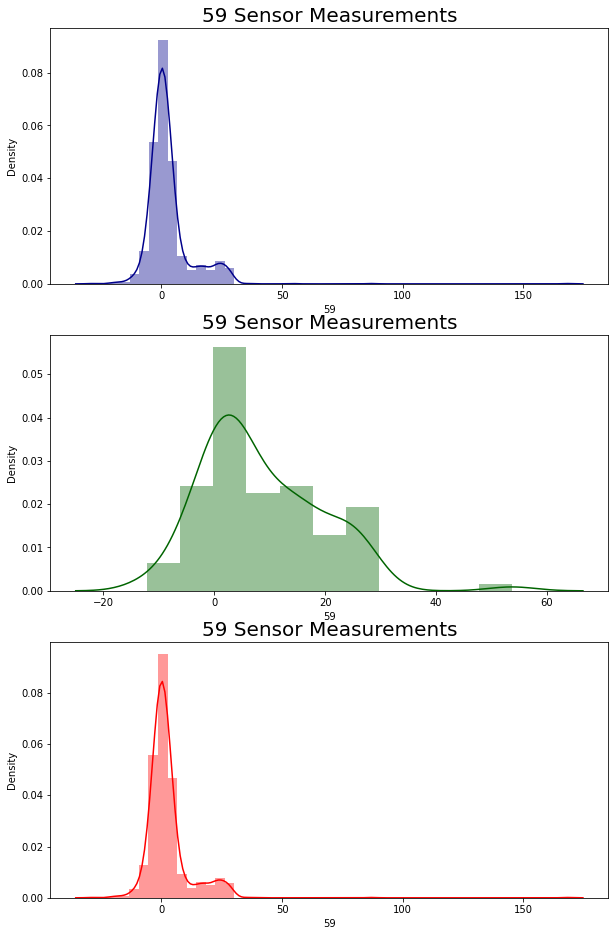

In [28]:
plt.rcParams['figure.figsize'] = (10, 16)

# 3x1 형태로 그래프를 출력하기 위하여 subplot을 설정 
 
plt.subplot(3, 1, 1)
sns.distplot(df['59'], color = 'darkblue')
plt.title('59 Sensor Measurements', fontsize = 20)

# 'Pass/Fail' 값이 1인 데이터를 출력.

plt.subplot(3, 1, 2)
sns.distplot(df[df['Pass/Fail']==1]['59'], color = 'darkgreen')
plt.title('59 Sensor Measurements', fontsize = 20)

# 'Pass/Fail' 값이 -1인 데이터를 출력.
plt.subplot(3, 1, 3)
sns.distplot(df[df['Pass/Fail']==-1]['59'], color = 'red')
plt.title('59 Sensor Measurements', fontsize = 20)